#### **Density Profile Measurements**:

Notebook for loading catalog data from illustristng sims:
* [TNG100-3](https://www.tng-project.org/data/downloads/TNG100-3/)

* [TNG300-3](https://www.tng-project.org/data/downloads/TNG300-3/)

Before loading catalogs clone [illustris_python](https://github.com/illustristng/illustris_python) repo which has nice functions for loading halos and create directories and subdirectories using the following naming conventions/hierarchy so that *illustris_python* can find the correct files (example below uses snapshot 66 of [TNG100-3](https://www.tng-project.org/data/downloads/TNG100-3/))

Folder Hierarchy (Follow this naming convention explicitly (changning numbers when appropriate) so that *illustris_python* works)
* TNG-100_3
  * outputs
      * groups_066
        * Group catalog downloads go here (see below)
      * snapdir_066
        * Snapshot catalog downloads go here (see below)
  * postprocessing
      * offsets
        * Offset file goes here

More info on this hierarchy that helps with loading catalogs can be found here [tutorial](https://www.tng-project.org/data/docs/scripts/).

##### **Load Group Catalog:**
Each snapshot has a group catalog which contains information about the halos within the catalog. The command for downloading the group catalog for a given snapshot of *TNG100-3* is found [here](https://www.tng-project.org/data/downloads/TNG100-3/). For snapshot 66 use

```
wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 67ac26a93ee04fc0669037ecfcf189d7" "http://www.tng-project.org/api/TNG100-3/files/groupcat-66/?format=api"
```

Make sure the group catalog files are downloaded in the directory *groups_066*.


In [1]:
import illustris_python as il

basePath = './TNG-100_3/outputs/' # Folder where snapshots and group catalogs are stored
snapshot_ind = 66

# Load header file
header = il.groupcat.loadHeader(basePath, snapshot_ind)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)
print("Header File Keys: ")
print('\n'.join(list(header.keys())))

# Load halo group quantities 
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)
print("\nHalo Group File Keys: ")
print('\n'.join(list(halo_grp.keys())))

# You can also specify the fields when loading halos to load what you want
halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_R_Crit200', 'Group_R_Mean200']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)

Header File Keys: 
BoxSize
FlagDoubleprecision
Git_commit
Git_date
HubbleParam
Ngroups_ThisFile
Ngroups_Total
Nids_ThisFile
Nids_Total
Nsubgroups_ThisFile
Nsubgroups_Total
NumFiles
Omega0
OmegaLambda
Redshift
Time

Halo Group File Keys: 
count
GroupBHMass
GroupBHMdot
GroupCM
GroupFirstSub
GroupGasMetalFractions
GroupGasMetallicity
GroupLen
GroupLenType
GroupMass
GroupMassType
GroupNsubs
GroupPos
GroupSFR
GroupStarMetalFractions
GroupStarMetallicity
GroupVel
GroupWindMass
Group_M_Crit200
Group_M_Crit500
Group_M_Mean200
Group_M_TopHat200
Group_R_Crit200
Group_R_Crit500
Group_R_Mean200
Group_R_TopHat200


##### **Load Snapshot and Offsets:**

To actually analyze the particles within the sim, you will need to load the snapshot and offset catalogs. Note the snapshot catalogs are substantially larger than the group catalogs. The command for downloading the snapshot catalog for each snapshot of TNG100-3 can be found [here](https://www.tng-project.org/data/downloads/TNG100-3/). For snapshot 66 use
```
wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 67ac26a93ee04fc0669037ecfcf189d7" "http://www.tng-project.org/api/TNG100-3/files/snapshot-66/?format=api"

```
Make sure this file is downloaded to the *snapdir_066* directory. To load the offsets for snapshot 66 use
```
wget --content-disposition --header="API-Key: 67ac26a93ee04fc0669037ecfcf189d7" "http://www.tng-project.org/api/TNG100-3/files/offsets.66.hdf5"
```

Can now load and analyze a halo as seen below

<Figure size 432x288 with 0 Axes>

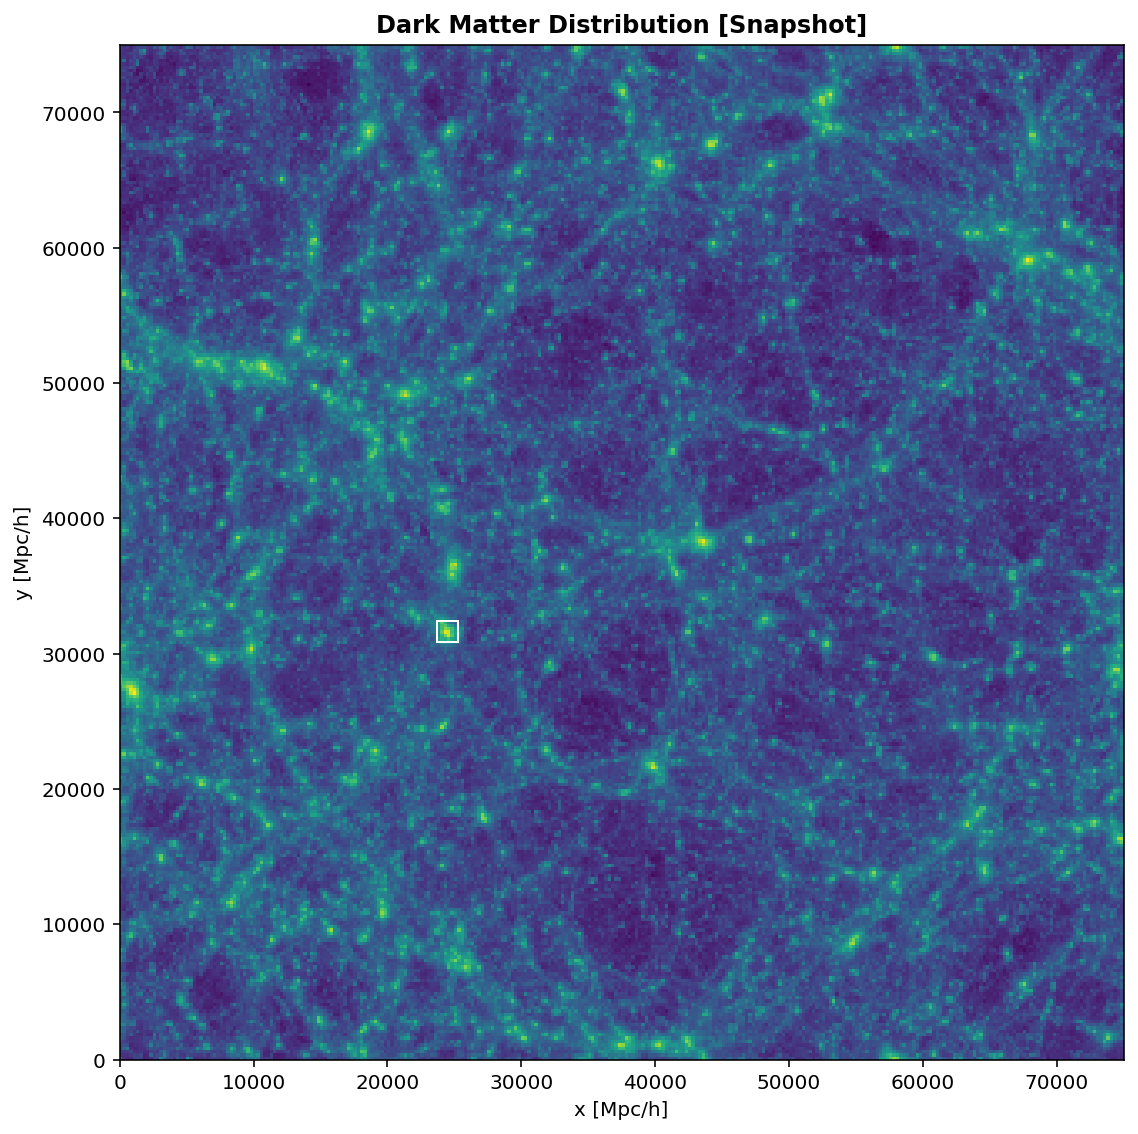

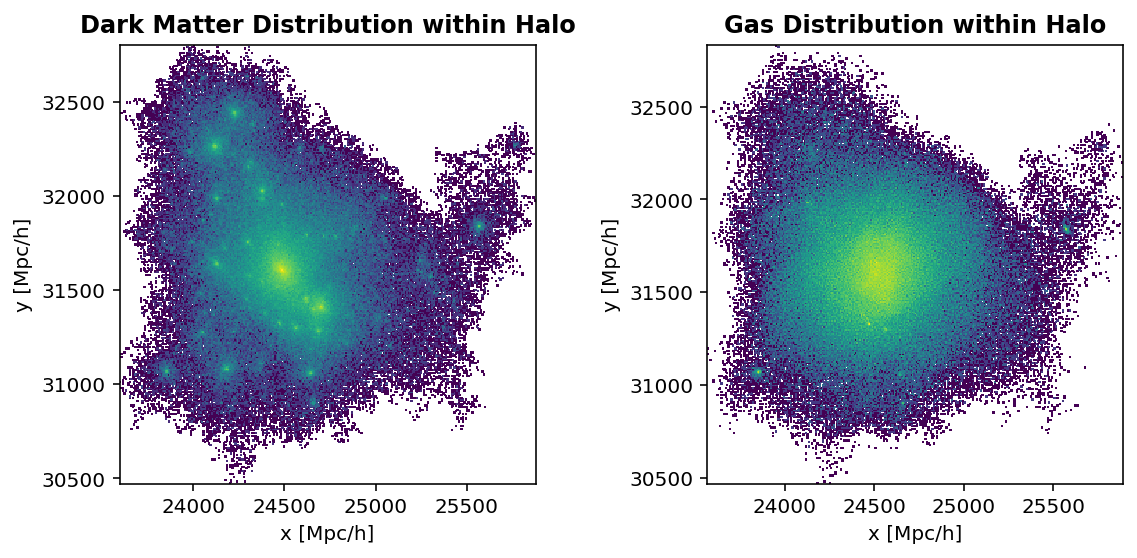

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

%config InlineBackend.figure_format ='retina'

# Choose index of halo to analze (sorted by increasing mass)
halo_ind = 3 
assert(halo_ind >= 0 and halo_ind < halo_grp['count']) 

halo_cm = halo_grp['GroupCM'][halo_ind]
halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind, 'gas')
halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')

dm_pos = il.snapshot.loadSubset(basePath, snapshot_ind, 'dm', ['Coordinates'])
halo_gas_pos = halo_gas['Coordinates']
halo_dm_pos = halo_dm['Coordinates']
halo_R_Mean200 = halo_grp['Group_R_Mean200'][snapshot_ind]

# Plot dark matter distribution
plt.figure(1)
plt.figure(figsize=(8, 8))
plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=colors.LogNorm(), bins=300)

# Plot box around selected halo
rec = plt.Rectangle((halo_cm[0]-1.5*halo_R_Mean200, halo_cm[1]-1.5*halo_R_Mean200), 
                    3*halo_R_Mean200, 3*halo_R_Mean200, ec="white", fill=None)
plt.gca().add_patch(rec)

plt.xlim(np.array([0,75000]))
plt.ylim(np.array([0,75000]))
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title("Dark Matter Distribution [Snapshot]", fontweight="bold")
plt.tight_layout()

# Plot gas and dark matter particle distributions within second halo
plt.figure(2)
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist2d(halo_dm_pos[:,0], halo_dm_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title("Dark Matter Distribution within Halo", fontweight="bold")

plt.subplot(1,2,2)
plt.hist2d(halo_gas_pos[:,0], halo_gas_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')
plt.title("Gas Distribution within Halo", fontweight="bold")

plt.tight_layout()